# Using a MLP on lung scans to detect COVID-19

#### Background

We'll be using data from Kaggle. While there are a few different COVID-19 scans data sets, we picked one that is large enough in order to split our data into training/testing/validation sets, but not so large that it takes a long time to train.

This is a publicly available SARS-CoV-2 CT scan dataset, containing 1252 CT scans that are positive for SARS-CoV-2 infection (COVID-19) and 1229 CT scans for patients non-infected by SARS-CoV-2, 2481 CT scans in total. These data have been collected from real patients in hospitals from Sao Paulo, Brazil.

**Please Note:** The description of the dataset on Kaggle says that there are 1230 negative CT scans, but it is actually 1229.

*Warning: Each time you want to re-run a model, you need to start fresh, i.e. "Disconnect and delete runtime" otherwise your model will overfit the data.* 

If you disconnect and delete the runtime, you will need to re-upload the `kaggle.json` file (this file will be obtained in the next step).


## Connect to Kaggle API & Import Libraries

While the data set could be downloaded from Kaggle via your browser and then you could upload all of the data into your notebook, that is not efficient. Thus, we want to connect to Kaggle so that we can download the data diectly. Here is the process.

1. Go to kaggle.com and log-in or create an account.
2. On the upper tab, click on 'Account'.
3. Once you do that, you'll see API and below that, "Create New API Token."
4. After clicking the "Create New API Token," a file named "kaggle.json" will be downloaded.
5. Upload this file into your Colab notebook, just as you would with a data set.

**Please Note:** You can reuse the same .json file, you don't need to create a new API token each time you want to connect to Kaggle.

Before proceeding to the code immediately below, make sure to place kaggle.json in your Colab notebook Files.

This folder deletion command is specific to Google Colab. We're making sure that our runtime doesn't have any of the files or folders that will be created in later steps to make sure that we can run these code cells from top to bottom without error or need for user input when we restart the notebook's runtime.

We're also deleting Google Colab's default `sample_data` folder so that this sample data doesn't accidentally get mixed in with our image data.

In [ ]:
# Remove folders and zip file from Kaggle
# So that we can re-run cells below if necessary
!rm -rf COVID non-COVID sarscov2-ctscan-dataset.zip sample_data dataset

In [ ]:
# We are using Unix commands (each begins with '!') to connect to Kaggle and get the data.
# Set-up the Kaggle directory
!mkdir -p ~/.kaggle

# Copy the json file to this new directory.
!cp kaggle.json ~/.kaggle/

# Allow access to the directory
!chmod 600 ~/.kaggle/kaggle.json

# List the names of the files in the directory
!ls ~/.kaggle

kaggle.json


In [ ]:
# Install Kaggle packages
!pip install -q kaggle
!pip install -q kaggle-cli

# Download the data set
!kaggle datasets download -d plameneduardo/sarscov2-ctscan-dataset

# If you get any errors, its likely due to conflicts in the Python versions and the Unix versions,
# but they should not be an issue. They are more warnings, then errors.

     |████████████████████████████████| 74 kB 3.3 MB/s 
     |████████████████████████████████| 4.2 MB 65.7 MB/s 
     |████████████████████████████████| 147 kB 66.7 MB/s 
     |████████████████████████████████| 49 kB 4.0 MB/s 
     |████████████████████████████████| 112 kB 70.3 MB/s 
  ERROR: Failed building wheel for lxml
    Running setup.py install for lxml ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-ojusc1la/lxml_aff5e0d72e2144ab84e6f3540b014ad5/setup.py'"'"'; __file__='"'"'/tmp/pip-install-ojusc1la/lxml_aff5e0d72e2144ab84e6f3540b014ad5/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-40uwcavg/install-record.txt --s

In [ ]:
# Unzip the data
!unzip sarscov2-ctscan-dataset.zip

Archive:  sarscov2-ctscan-dataset.zip
  inflating: COVID/Covid (1).png     
  inflating: COVID/Covid (10).png    
  inflating: COVID/Covid (100).png   
  inflating: COVID/Covid (1000).png  
  inflating: COVID/Covid (1001).png  
  inflating: COVID/Covid (1002).png  
  inflating: COVID/Covid (1003).png  
  inflating: COVID/Covid (1004).png  
  inflating: COVID/Covid (1005).png  
  inflating: COVID/Covid (1006).png  
  inflating: COVID/Covid (1007).png  
  inflating: COVID/Covid (1008).png  
  inflating: COVID/Covid (1009).png  
  inflating: COVID/Covid (101).png   
  inflating: COVID/Covid (1010).png  
  inflating: COVID/Covid (1011).png  
  inflating: COVID/Covid (1012).png  
  inflating: COVID/Covid (1013).png  
  inflating: COVID/Covid (1014).png  
  inflating: COVID/Covid (1015).png  
  inflating: COVID/Covid (1016).png  
  inflating: COVID/Covid (1017).png  
  inflating: COVID/Covid (1018).png  
  inflating: COVID/Covid (1019).png  
  inflating: COVID/Covid (102).png   
  inflating:

Before we look at the data, let's import our libraries.

In [ ]:
# File / Directory Management Imports
import pathlib
import PIL
import os

# MLP Imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation, ReLU, Rescaling
from tensorflow.keras.optimizers import Adam

# Callback Imports
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

# GridSearch Imports
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import ParameterGrid

# Regularization Imports
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import MaxNorm

import warnings
warnings.filterwarnings('ignore')

## Explore the CT Scan Images

The CT scan images in this dataset correspond to one of two diagnoses: `Covid` and `Non-Covid`. We will store the images from each respective class in its own folder.

We will verify that we have the expected number of images and take a look at a few of them.

In [ ]:
# Create folders for the two types of data.

# data_dir_covid = pathlib.Path('../content/COVID')
# data_dir_non_covid = pathlib.Path('../content/non-COVID')

data_dir_covid = pathlib.Path('COVID')
data_dir_non_covid = pathlib.Path('non-COVID')

# Count the number of .png files in each folder.

img_count_covid = len(list(data_dir_covid.glob('*.png'))) 
img_count_non_covid = len(list(data_dir_non_covid.glob('*.png'))) 

print("Image count in Covid set: ", img_count_covid)
print("Image count in Non-Covid set: ", img_count_non_covid)
print("Total Image count: ", (img_count_covid+img_count_non_covid))

Image count in Covid set:  1252
Image count in Non-Covid set:  1229
Total Image count:  2481


In [ ]:
# Grab the images and store them in a list
# So that we can display a few of them.

# data_dir_train = pathlib.Path('COVID')

covid = list(data_dir_covid.glob('*.png'))
non_covid = list(data_dir_non_covid.glob('*.png'))

Change the `image_index` variable below to look at different images.

Image Size:  (368, 298)


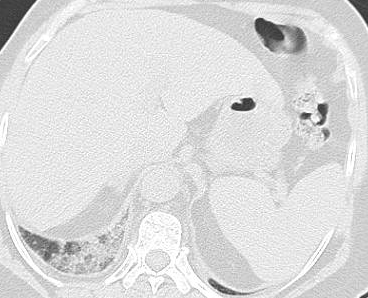

In [ ]:
# CT Scans diagnosed as Covid

image_index = 0

# Print the Image Dimensions
img = PIL.Image.open(covid[image_index])

print("Image Size: ", img.size)

# Look at the Image
img

Image Size:  (285, 181)


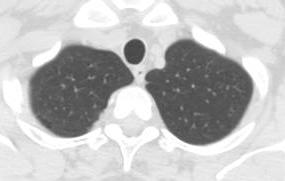

In [ ]:
# CT Scans diagnosed as Non-Covid

image_index = 0

# Print the Image Dimensions
img = PIL.Image.open(non_covid[image_index])

print("Image Size: ", img.size)

# Look at the Image
img

## Create folders for Train, Validation and Test

We will use the `split-folders` Python package to create train, val, and test folders. We will put these within an outer folder called `dataset`. 

- Train (70%) 
- Validation (20%)
- Test (10%)



In [ ]:
# We'll use split-folders to combine the two types of data (Covid/Non-Covid)
# and to further split into train/test/validaiton sets.

# Install split-folders
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Using split-folders to split source folder into the
# train (70%), validation (20%), and test (10%).

# Set the seed to 1337, so that we can replicate the results.

import splitfolders
splitfolders.ratio("../content", output="../content/dataset",
    seed=1337, ratio=(.7, .2, .1), group_prefix=None, move=False)

Copying files: 2484 files [00:00, 2647.31 files/s]


In [ ]:
# Define the path for train, validation and test set

data_dir_train = pathlib.Path('dataset/train')
data_dir_test = pathlib.Path('dataset/test')
data_dir_val = pathlib.Path('dataset/val')

# Check the total image counts (all images are of type .png).
img_count_train = len(list(data_dir_train.glob('*/*.png'))) 
img_count_test = len(list(data_dir_test.glob('*/*.png'))) 
img_count_val = len(list(data_dir_val.glob('*/*.png'))) 

img_count_tot = img_count_train + img_count_test + img_count_val

print("Image count in Train set: ", img_count_train)
print("Image count in Val set: ", img_count_val)
print("Image count in Test set: ", img_count_test)
print("Total image count", img_count_tot)

Image count in Train set:  1736
Image count in Val set:  495
Image count in Test set:  250
Total image count 2481


## Preprocessing and Helper Functions

### Create a "Data Generator"

A Data Generator allows Python to be more efficient in loading the image data as the neural network is training. This is particular important for visual data. This Data Generator will be in charge of resizing the images and preparing each batch to be used during each epoch of training. So We'll need to set these parameters before creating the Data Generator.

Keras has built-in data generator called `ImageDataGenerator`, but it has limited flexibility. So, we'll create our own.

In [ ]:
# Data Generator Parameters
batch_size = 32
img_height = 32
img_width = 32

In [ ]:
# Custom data generator

def data_generator(data_source, img_height, img_width, btc_size):    
    return tf.keras.utils.image_dataset_from_directory(
        data_source,
        validation_split=None, # We already split the data
        subset=None,
        seed=123,
        color_mode='grayscale',
        image_size=(img_height, img_width),
        batch_size=btc_size,
        crop_to_aspect_ratio=True,
        shuffle=True,
    )

train_ds = data_generator(data_dir_train, img_height, img_width, batch_size)
val_ds = data_generator(data_dir_val, img_height, img_width, batch_size)
test_ds = data_generator(data_dir_test, img_height, img_width, batch_size)

Found 1736 files belonging to 3 classes.
Found 495 files belonging to 3 classes.
Found 250 files belonging to 3 classes.


The "Data Generator" will create a y-variable with corresponding label integers using the folder names found within the each of the `dataset/train`, `dataset/val`, and `dataset/test` folders. Because we want this task to be **binary classification** we need to make sure that there are no other folders or files lurking around in these three folders.

It may say "belonging to 3 classes." or "belonging to 4 classes." above. That's bad. We only want there to be two classes. Let's see what else might be hiding in these folders.

In [ ]:
print("Things in the train folder: ", train_ds.class_names)
print("Things in the val folder: ", val_ds.class_names)
print("Things in the test folder: ", test_ds.class_names)

Things in the train folder:  ['.config', 'COVID', 'non-COVID']
Things in the val folder:  ['.config', 'COVID', 'non-COVID']
Things in the test folder:  ['.config', 'COVID', 'non-COVID']


If you see a `.config` folder or `.ipynb_checkpoints` in any of the there folders, those need to be removed and the dataset variables `train_ds`, `val_ds`, and `test_ds` re-generated. 

In [ ]:
# delete pesky `.config` hidden folder

!rm -rf dataset/train/.config
!rm -rf dataset/test/.config
!rm -rf dataset/val/.config

In [ ]:
train_ds = data_generator(data_dir_train, img_height, img_width, batch_size)
val_ds = data_generator(data_dir_val, img_height, img_width, batch_size)
test_ds = data_generator(data_dir_test, img_height, img_width, batch_size)

Found 1736 files belonging to 2 classes.
Found 495 files belonging to 2 classes.
Found 250 files belonging to 2 classes.


Much better. Feel free to add additional `!rm -rf` commands above if you need to delete any additional folders.

In [ ]:
print("Things in the train folder: ", train_ds.class_names)
print("Things in the val folder: ", val_ds.class_names)
print("Things in the test folder: ", test_ds.class_names)

Things in the train folder:  ['COVID', 'non-COVID']
Things in the val folder:  ['COVID', 'non-COVID']
Things in the test folder:  ['COVID', 'non-COVID']


## GridSearch

Since doing a basic Grid Search is something that you'll be asked to do on the Sprint Challenge, we wanted to give some example code here just as a reminder about what is required to make that happen.

- Import `GridSearchCV` and `KerasClassifier`
- Create a "Build Function" (`build_fn`) that can take in as parameters the values that you want to experiment with
- Set up a `param_grid` dictionary that holds the different values that you would like to try. Remember that the total number of fitted models will be however many different combinations of hyperparameters that you're wanting to test against each other multiplied by the number of folds of cross validation. In the example below we would be fitting our neural network 12 times just to experiment with the four different values in our `param_grid`.
- Use `KerasClassifier` to create a model that is compatible with the Scikit-Learn GirdSearchCV class, and then fit the gridsearch passing in the `param_grid`.

--- 

*Please Note:* On the Sprint Challenge CodeGrade will only have one worker and cannot handle multi-threaded processes so you **must** use the parameter `n_jobs=1` on the Sprint Challenge when fitting your GridSearch or else the grader will crash and give you a 0. 

This isn't the absolute best model we could be using, but I wanted to use a little bit smaller of a model so that our code cells would run a little bit faster during this Code-Along

In [ ]:
# Build Function
def create_model(num_units=32, activation='sigmoid', kernel_regularizer=None, kernel_constraint=None):

    model = Sequential([
        Rescaling(1./255, input_shape=(img_height, img_width, 1)),
        Flatten(),
        Dense(num_units, activation=activation, kernel_regularizer=kernel_regularizer, kernel_constraint=kernel_constraint),
        Dense(32, activation=activation, kernel_regularizer=kernel_regularizer, kernel_constraint=kernel_constraint),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=.0001),
                loss='binary_crossentropy',
                metrics=['accuracy'])
    
    return model

In [ ]:
param_grid = {'activation': ['sigmoid', 'relu'],
              'num_units': [32, 64]}

### We've got a problem

GridSearch is great, but it just so happens that `GridSearchCV` does **not** work well with our `data_generator` function that loads the images from the folders that we have created. So we won't be able to do the final step of actually executing the GridSearch. 

In [ ]:
model = KerasClassifier(build_fn=create_model)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=2, cv=3)
# GridSearchCV does not work with loading image data from directories. :(
# grid_result = grid.fit(?????????)

A quick peek at the documentation will reveal that GridSearchCV doesn't have a way of accepting our folder-based image batches.

In [ ]:
?grid.fit

So we'll leave the code above for your edification, but we won't be able to actually fit a GridSearchCV with this dataset. We could do a super custom fancy-schmancy implementation of our own GridSearch, but that goes well beyond our learning objectives and the time that we have available. 


### An inadequate work-around 

Below is an approach that will at least allow us to use our `param_grid` dictionary and `create_model` function to run experiments with all of the different combinations of hyperparameters that we have specified. However, it does *not* include any form of Cross-Validation, (We're also only running each experiment for 3 epochs each, which is certainly insufficient) so the final results of our experiments are subject to quite a bit of random variation. 

We'll use TensorBoard to keeep track of and display the results of the different experiments

In [ ]:
%load_ext tensorboard

In [ ]:
# Clear any logs from previous runs for tensorboard
!rm -rf ./logs/

In [ ]:
# Generate all of the different combinations of hyperparameters
list(ParameterGrid(param_grid))

[{'activation': 'sigmoid', 'num_units': 32},
 {'activation': 'sigmoid', 'num_units': 64},
 {'activation': 'relu', 'num_units': 32},
 {'activation': 'relu', 'num_units': 64}]

In [ ]:
for experiment in ParameterGrid(param_grid):

    # generate a name for the experiment from the hyperparameters
    experiment_name = '_'.join(map(str, experiment.values()))
    print("Running experiment for:", experiment_name)

    # Directory where we will save the results of our experiment
    logdir = os.path.join('logs', experiment_name)

    # Create the TensorBoard Callback
    tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

    # Generate model with specific hyperparameters
    model = create_model(activation=experiment['activation'], num_units=experiment['num_units'])
    
    # fit the model and save the results to tensorboard
    model.fit(train_ds, epochs=3, validation_data=val_ds, workers=2, verbose=1, callbacks=[tensorboard_callback])

Running experiment for: sigmoid_32
Epoch 1/3
55/55 [==============================] - 10s 145ms/step - loss: 0.7021 - accuracy: 0.5046 - val_loss: 0.6939 - val_accuracy: 0.5091
Epoch 2/3
55/55 [==============================] - 9s 142ms/step - loss: 0.6921 - accuracy: 0.5012 - val_loss: 0.6894 - val_accuracy: 0.5071
Epoch 3/3
55/55 [==============================] - 9s 141ms/step - loss: 0.6876 - accuracy: 0.5253 - val_loss: 0.6846 - val_accuracy: 0.5051
Running experiment for: sigmoid_64
Epoch 1/3
55/55 [==============================] - 9s 145ms/step - loss: 0.7146 - accuracy: 0.5012 - val_loss: 0.6963 - val_accuracy: 0.4747
Epoch 2/3
55/55 [==============================] - 8s 127ms/step - loss: 0.6940 - accuracy: 0.4729 - val_loss: 0.6912 - val_accuracy: 0.5051
Epoch 3/3
55/55 [==============================] - 8s 129ms/step - loss: 0.6893 - accuracy: 0.5444 - val_loss: 0.6859 - val_accuracy: 0.5051
Running experiment for: relu_32
Epoch 1/3
55/55 [==============================] - 

In [ ]:
%tensorboard --logdir logs

Clear out the logs from our GridSearch so that we can compare and contrast thedifferent Regularization Techniques.

In [ ]:
# Delete any logs from previous runs
!rm -rf ./logs/

## Early Stopping Regularization

In [ ]:
# Create folder to store results
logdir = os.path.join('logs', 'EarlyStopping')

# Create a TensorBoard Callback to store the model's progress after each epoch
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Create an EarlyStopping Callback that will terminate training if improvement slows.
stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2)

# Create a custom model
model = create_model(activation='relu', num_units=64)

# Fit the model
model.fit(train_ds,
         epochs=99,
         validation_data=val_ds,
         workers=2,
         verbose=1,
         callbacks=[tensorboard_callback, stop]) #include early stopping callback

Epoch 1/99
55/55 [==============================] - 10s 151ms/step - loss: 0.6690 - accuracy: 0.5685 - val_loss: 0.6521 - val_accuracy: 0.6263
Epoch 2/99
55/55 [==============================] - 9s 147ms/step - loss: 0.6299 - accuracy: 0.6544 - val_loss: 0.6269 - val_accuracy: 0.6040
Epoch 3/99
55/55 [==============================] - 8s 132ms/step - loss: 0.6120 - accuracy: 0.6694 - val_loss: 0.6045 - val_accuracy: 0.6828
Epoch 4/99
55/55 [==============================] - 8s 133ms/step - loss: 0.5872 - accuracy: 0.6953 - val_loss: 0.6062 - val_accuracy: 0.6687
Epoch 5/99
55/55 [==============================] - 8s 133ms/step - loss: 0.5689 - accuracy: 0.7126 - val_loss: 0.5707 - val_accuracy: 0.7192
Epoch 6/99
55/55 [==============================] - 8s 133ms/step - loss: 0.5639 - accuracy: 0.7154 - val_loss: 0.5826 - val_accuracy: 0.6788
Epoch 7/99
55/55 [==============================] - 9s 148ms/step - loss: 0.5534 - accuracy: 0.7270 - val_loss: 0.5570 - val_accuracy: 0.7192
Epoch

In [ ]:
%tensorboard --logdir logs

## L1 Regularization

In [ ]:


# Create folder to store results
logdir = os.path.join('logs', 'EarlyStopping+L1')
# Create a TensorBoard Callback to store the model's progress after each epoch
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
# Create an EarlyStopping Callback that will terminate training if improvement slows.
stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2)
# Create a custom model
model = create_model(activation='relu', num_units=64, kernel_constraint=MaxNorm(max_value=2, axis=0))
# Fit the model
model.fit(train_ds,
         epochs=99,
         validation_data=val_ds,
         workers=2,
         verbose=1,
         callbacks=[tensorboard_callback, stop])

Epoch 1/99
55/55 [==============================] - 9s 137ms/step - loss: 0.6643 - accuracy: 0.6066 - val_loss: 0.6518 - val_accuracy: 0.6485
Epoch 2/99
55/55 [==============================] - 8s 130ms/step - loss: 0.6420 - accuracy: 0.6417 - val_loss: 0.6293 - val_accuracy: 0.6828
Epoch 3/99
55/55 [==============================] - 9s 147ms/step - loss: 0.6237 - accuracy: 0.6682 - val_loss: 0.6108 - val_accuracy: 0.6970
Epoch 4/99
55/55 [==============================] - 8s 129ms/step - loss: 0.6086 - accuracy: 0.6866 - val_loss: 0.6005 - val_accuracy: 0.6828
Epoch 5/99
55/55 [==============================] - 8s 129ms/step - loss: 0.5926 - accuracy: 0.6953 - val_loss: 0.5794 - val_accuracy: 0.7172
Epoch 6/99
55/55 [==============================] - 8s 132ms/step - loss: 0.5727 - accuracy: 0.7166 - val_loss: 0.5802 - val_accuracy: 0.6848
Epoch 7/99
55/55 [==============================] - 9s 147ms/step - loss: 0.5661 - accuracy: 0.7062 - val_loss: 0.5599 - val_accuracy: 0.7293
Epoch 

In [ ]:
%tensorboard --logdir logs

## L2 Regularization

In [ ]:
# Create folder to store results
logdir = os.path.join('logs', 'EarlyStopping+L2')
# Create a TensorBoard Callback to store the model's progress after each epoch
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
# Create an EarlyStopping Callback that will terminate training if improvement slows.
stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2)
# Create a custom model
model = create_model(activation='relu', num_units=64, kernel_regularizer=l2(0.001))
# Fit the model
model.fit(train_ds,
         epochs=99,
         validation_data=val_ds,
         workers=2,
         verbose=1,
         callbacks=[tensorboard_callback, stop])

Epoch 1/99
55/55 [==============================] - 10s 152ms/step - loss: 0.8465 - accuracy: 0.5282 - val_loss: 0.8139 - val_accuracy: 0.6747
Epoch 2/99
55/55 [==============================] - 9s 150ms/step - loss: 0.8057 - accuracy: 0.6215 - val_loss: 0.7830 - val_accuracy: 0.6182
Epoch 3/99
55/55 [==============================] - 8s 131ms/step - loss: 0.7767 - accuracy: 0.6676 - val_loss: 0.7565 - val_accuracy: 0.7192
Epoch 4/99
55/55 [==============================] - 8s 132ms/step - loss: 0.7583 - accuracy: 0.6757 - val_loss: 0.7733 - val_accuracy: 0.5556
Epoch 5/99
55/55 [==============================] - 9s 148ms/step - loss: 0.7388 - accuracy: 0.6918 - val_loss: 0.7230 - val_accuracy: 0.7071
Epoch 6/99
55/55 [==============================] - 9s 147ms/step - loss: 0.7257 - accuracy: 0.6947 - val_loss: 0.7104 - val_accuracy: 0.7172
Epoch 7/99
55/55 [==============================] - 8s 131ms/step - loss: 0.7097 - accuracy: 0.7206 - val_loss: 0.6978 - val_accuracy: 0.7192
Epoch

In [ ]:
%tensorboard --logdir logs

## Dropout Regularization

In [ ]:
# Create folder to store results
logdir = os.path.join('logs', 'EarlyStopping+Dropout')

# Create a TensorBoard Callback to store the model's progress after each epoch
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Create an EarlyStopping Callback that will terminate training if improvement slows.
stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2)

# Create a custom model
model = Sequential([
        Rescaling(1./255, input_shape=(img_height, img_width, 1)),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(.2),
        Dense(32, activation='relu'),
        Dropout(.2),
        Dense(1, activation='sigmoid')
    ])

model.compile(optimizer=Adam(learning_rate=.0001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Fit the model
model.fit(train_ds,
         epochs=99,
         validation_data=val_ds,
         workers=2,
         verbose=1,
         callbacks=[tensorboard_callback, stop])

Epoch 1/99
55/55 [==============================] - 9s 137ms/step - loss: 0.6821 - accuracy: 0.5645 - val_loss: 0.6477 - val_accuracy: 0.6545
Epoch 2/99
55/55 [==============================] - 9s 147ms/step - loss: 0.6586 - accuracy: 0.5927 - val_loss: 0.6311 - val_accuracy: 0.6606
Epoch 3/99
55/55 [==============================] - 9s 143ms/step - loss: 0.6382 - accuracy: 0.6112 - val_loss: 0.6069 - val_accuracy: 0.7030
Epoch 4/99
55/55 [==============================] - 9s 143ms/step - loss: 0.6223 - accuracy: 0.6555 - val_loss: 0.5931 - val_accuracy: 0.7051
Epoch 5/99
55/55 [==============================] - 9s 145ms/step - loss: 0.6126 - accuracy: 0.6596 - val_loss: 0.5851 - val_accuracy: 0.6949
Epoch 6/99
55/55 [==============================] - 9s 145ms/step - loss: 0.6066 - accuracy: 0.6676 - val_loss: 0.5719 - val_accuracy: 0.7152
Epoch 7/99
55/55 [==============================] - 9s 151ms/step - loss: 0.5862 - accuracy: 0.6884 - val_loss: 0.5694 - val_accuracy: 0.7131
Epoch 

In [ ]:
%tensorboard --logdir logs